In [1]:
from pathlib import Path
import torch
import numpy as np
import pandas as pd
import imgaug
from imgaug.augmentables.bbs import BoundingBox


In [2]:
class CardiacDataset(torch.utils.data.Dataset):

    def __init__(self, path_to_labels_csv, patients, root_path, augs):
        
        self.labels = pd.read_csv(path_to_labels_csv)
        
        self.patients = np.load(patients)
        self.root_path = Path(root_path)
        self.augment = augs
        
    def  __len__(self):
        """
        Returns the length of the dataset
        """
        return len(self.patients)
        
    def __getitem__(self, idx):
        """
        Returns an image paired with bbox around the heart
        """
        patient = self.patients[idx]
        # Get data according to index
        data = self.labels[self.labels["name"]==patient]
        
        # Get entries of given patient
        # Extract coordinates
        
        x_min = data["x0"].item()
        y_min = data["y0"].item()
        x_max = x_min + data["w"].item()  # get xmax from width
        y_max = y_min + data["h"].item()  # get ymax from height
        bbox = [x_min, y_min, x_max, y_max]


        # Load file and convert to float32
        file_path = self.root_path/patient  # Create the path to the file
        img = np.load(f"{file_path}.npy").astype(np.float32)
        
        
        # Apply imgaug augmentations to image and bounding box
        if self.augment:
            
            bb = BoundingBox(x1=bbox[0], y1=bbox[1], x2=bbox[2], y2=bbox[3])
            
            ###################IMPORTANT###################
            # Fix for https://discuss.pytorch.org/t/dataloader-workers-generate-the-same-random-augmentations/28830/2
            # https://github.com/pytorch/pytorch/issues/5059
            random_seed = torch.randint(0, 1000000, (1,)).item()
            imgaug.seed(random_seed)
            #####################################################

            img, aug_bbox  = self.augment(image=img, bounding_boxes=bb)
            bbox = aug_bbox[0][0], aug_bbox[0][1], aug_bbox[1][0], aug_bbox[1][1]
            
            
        # Normalize the image according to the values computed in Preprocessing
        img = (img - 0.494) / 0.252

        img = torch.tensor(img).unsqueeze(0)
        bbox = torch.tensor(bbox)
            
        return img, bbox


In [3]:
import imgaug.augmenters as iaa
import matplotlib.pyplot as plt
import matplotlib.patches as patches


In [4]:
seq = iaa.Sequential([
    iaa.GammaContrast(),
    iaa.Affine(
    scale = (0.8,1.2),
    rotate = (-10,10),
    translate_px=(-10,10))
])

In [5]:
labels_path = "C:/Users/Owner/Downloads/Udemy/Pytorch/05-Detection/05-Detection/rsna_heart_detection.csv"
patients_path = "C:/Users/Owner/Downloads/Udemy/Pytorch/05-Detection/05-Detection/train_subjects.npy"
train_root = "C:/Users/Owner/Downloads/Udemy/Pytorch/05-Detection/Processed-Heart-Detection/train/"
dataset = CardiacDataset(labels_path, patients_path, train_root, seq)

In [6]:
labels_path

'C:/Users/Owner/Downloads/Udemy/Pytorch/05-Detection/05-Detection/rsna_heart_detection.csv'

In [7]:
patients_path

'C:/Users/Owner/Downloads/Udemy/Pytorch/05-Detection/05-Detection/train_subjects.npy'

In [8]:
train_root

'C:/Users/Owner/Downloads/Udemy/Pytorch/05-Detection/Processed-Heart-Detection/train/'

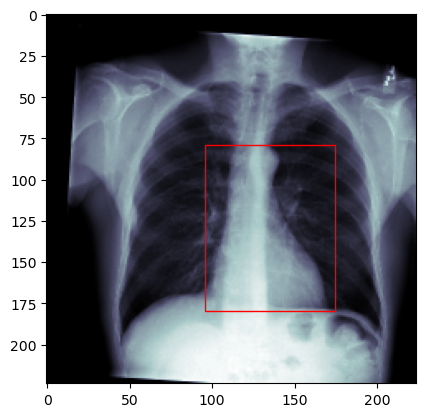

In [11]:
img, bbox = dataset[0]

fig, axis = plt.subplots(1,1)
axis.imshow(img[0],cmap="bone")
rect = patches.Rectangle((bbox[0], bbox[1]), bbox[2]-bbox[0], bbox[3]-bbox[1], edgecolor="r", facecolor="none")
axis.add_patch(rect)

tensor([ 77.7471,  63.4353, 165.5096, 166.8008])


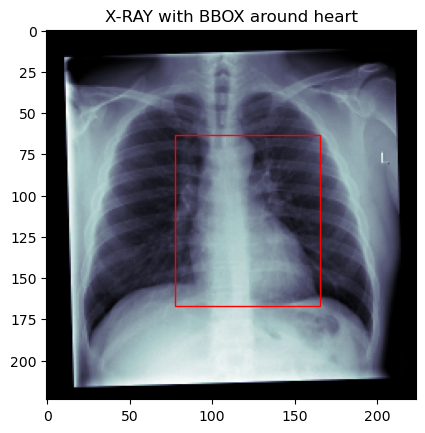

In [12]:
img, label = dataset[17]

fig, axis = plt.subplots(1, 1)
axis.imshow(img[0], cmap="bone")
spot1 = patches.Rectangle((label[0], label[1]), label[2]-label[0], label[3]-label[1], edgecolor='r', facecolor='none')
axis.add_patch(spot1)

axis.set_title("X-RAY with BBOX around heart")
print(label)